<h2 style="font-family: 'Arial', sans-serif; text-align: center; color: #4B8BBE;">
    Xây dựng mô hình Prophet trong dự báo doanh thu theo nhóm sản phẩm 
</h2>


In [1]:
import pyodbc
import numpy as np
import pandas as pd
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

import redshift_connector


conn = redshift_connector.connect(
    host     = "datnvn.870889396351.us-east-1.redshift-serverless.amazonaws.com",
    port     = 5439,
    database = "dev",
    user     = "admin",
    password  = 'Datn1234'
)

cursor = conn.cursor()

cursor.execute("SELECT b.*, s.nhomsp  FROM  Fact_BanHang b join Dim_sanpham s on b.masp = s.masp")
# Directly fetch the results as a pandas DataFrame
df = cursor.fetch_dataframe()
df.head(5)


,matg,madh,macn,manv,masp,makh,soluong,doanhthu,loinhuan,nhomsp
0,20221003,ĐH9811891,CN DN,NV248,P-347,KH-0608,9,354780000.0,118260000.0,Phần mềm
1,20221003,ĐH4485598,CN DN,NV247,P-340,KH-0550,7,1785000.0,595000.0,Phụ kiện
2,20221003,ĐH1539758,CN DN,NV058,P-724,KH-0157,6,4050000.0,1350000.0,Phần mềm
3,20221003,ĐH2490023,CN DN,NV207,P-248,KH-0593,7,4935000.0,1645000.0,Phần mềm
4,20221003,ĐH6321654,CN DN,NV195,P-334,KH-0681,9,36045000.0,12015000.0,Phụ kiện


In [2]:
# Kiểm tra các giá trị thống kê cơ bản
df.describe()

,matg,soluong,doanhthu,loinhuan
count,2.912900e+04,29129.000000,2.895600e+04,2.912500e+04
mean,2.023073e+07,6.047684,9.915063e+07,3.966611e+07
std,8.311830e+03,2.226735,2.249571e+08,1.118842e+08
min,2.022011e+07,1.000000,3.000000e+04,1.000000e+04
25%,2.022101e+07,5.000000,7.110000e+06,2.400000e+06
50%,2.023073e+07,6.000000,2.904750e+07,9.840000e+06
75%,2.024050e+07,7.000000,9.253125e+07,3.164000e+07
max,2.024123e+07,10.000000,2.138850e+09,2.053350e+09


In [3]:
df['matg'] = pd.to_datetime(df['matg'], format='%Y%m%d')
df.sort_values('matg', inplace=True)

df_pm = df[df['nhomsp'] == 'Phần mềm']
df_mt = df[df['nhomsp'] == 'Máy tính']
df_pk = df[df['nhomsp'] == 'Phụ kiện']

df_pm_monthly = df_pm.resample('M', on='matg')['doanhthu'].sum().reset_index()
df_mt_monthly = df_mt.resample('M', on='matg')['doanhthu'].sum().reset_index()
df_pk_monthly = df_pk.resample('M', on='matg')['doanhthu'].sum().reset_index()

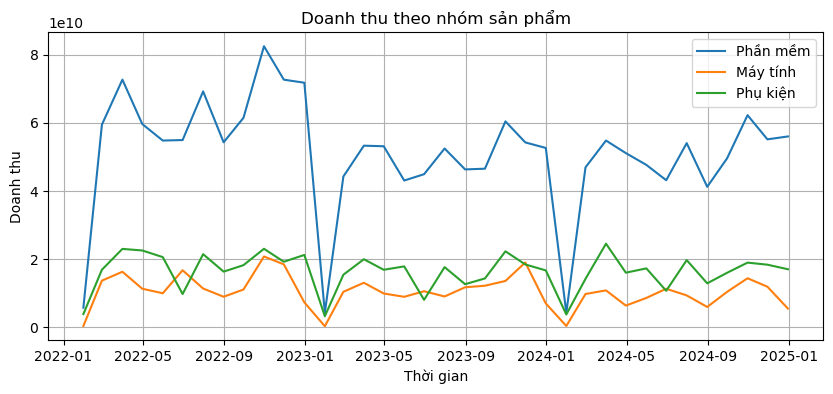

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df_pm_monthly['matg'], df_pm_monthly['doanhthu'], label='Phần mềm')
plt.plot(df_mt_monthly['matg'], df_mt_monthly['doanhthu'], label='Máy tính')
plt.plot(df_pk_monthly['matg'], df_pk_monthly['doanhthu'], label='Phụ kiện')
plt.legend()
plt.xlabel('Thời gian')
plt.ylabel('Doanh thu')
plt.title('Doanh thu theo nhóm sản phẩm')
plt.grid()
plt.show()


### Dự đoán doanh thu cho nhóm sản phẩm máy tính 

***Phân rã chuỗi thời gian***

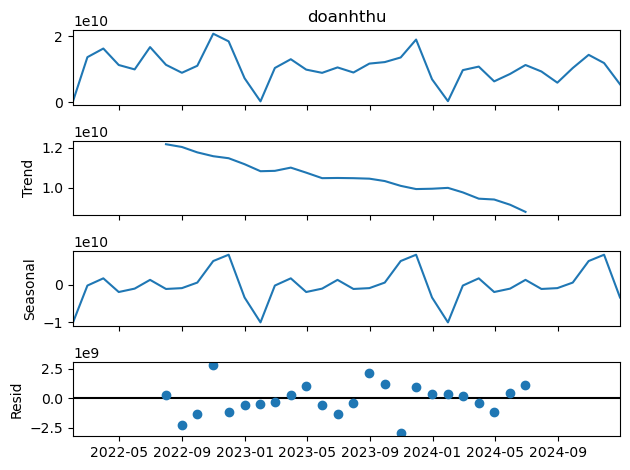

In [ ]:
import statsmodels.api as sm
ts_mt = df_mt_monthly.set_index('matg')['doanhthu']
res_add = sm.tsa.seasonal_decompose(ts_mt, model='additive', period=12)
res_add.plot()
plt.show()

Nhìn vào biểu đồ cho thấy không có tính mùa vụ theo tuần

### Tiền xử lý dữ liệu

In [6]:

# Đổi tên các cột để phù hợp với yêu cầu của Prophet:
# 'Order_Date' đổi thành 'ds' và 'Sales' đổi thành 'y' (giá trị cần dự báo)
monthly_data_mt = df_mt_monthly.rename(columns={'matg': 'ds', 'doanhthu': 'y'})

# Hiển thị 5 dòng đầu của dữ liệu đã xử lý
monthly_data_mt.head(5)


,ds,y
0,2022-01-31,3.654750e+08
1,2022-02-28,1.367290e+10
2,2022-03-31,1.628370e+10
3,2022-04-30,1.130366e+10
4,2022-05-31,9.971430e+09


***Huấn luyện mô hình***

In [7]:
from prophet import Prophet


# Tạo DataFrame chứa ngày lễ và ảnh hưởng chiến dịch
holidays = pd.DataFrame({
  'holiday': ['Tet2022', 'ChuyenDoiSo2022', 'Tet2023', 'ChuyenDoiSo2023', 'Tet2024', 'ChuyenDoiSo2024'],
  'ds': pd.to_datetime(['2022-02-01', '2022-10-10',  # Ngày bắt đầu ảnh hưởng Tết và ngày Chuyển đổi số
                         '2023-01-22', '2023-10-10',  # Tết và ngày Chuyển đổi số
                         '2024-02-10', '2024-10-10']),  # Tết và ngày Chuyển đổi số năm 2024
  'lower_window': [-7, -7, -7, -7, -7, -7],  # Ảnh hưởng trước ngày lễ (10 ngày trước Tết và ngày 10-10)
  'upper_window': [7, 1, 7, 1, 7, 1],        # Ảnh hưởng sau ngày lễ (7 ngày sau Tết, 1 ngày sau ngày 10-10)
})

holidays['ds'] = pd.to_datetime(holidays['ds'])  # Chuyển đổi thành datetime

# Khởi tạo mô hình Prophet
model = Prophet(holidays=holidays, 
                yearly_seasonality=True,   # Nếu có tính mùa vụ theo năm
                weekly_seasonality=False)  # Nếu không có mùa vụ theo tuần


# Huấn luyện mô hình Prophet với dữ liệu lịch sử
# Prophet sẽ học các đặc điểm trong dữ liệu như xu hướng (trend),
# mùa vụ (seasonality), và yếu tố bất thường (holidays/events).
model.fit(monthly_data_mt)

# Tạo một DataFrame mới chứa các mốc thời gian lịch sử và tương lai (12 tháng tiếp theo).
future = model.make_future_dataframe(periods=12, freq='M')

# Dự báo giá trị tương lai dựa trên mô hình Prophet đã huấn luyện
forecast = model.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 100000000))
# Lấy doanh thu thực tế trong dữ liệu lịch sử
actual_data_mt = monthly_data_mt['y']

# Lấy giá trị dự báo mà Prophet đã khớp trên dữ liệu lịch sử (fitted values)
fitted_data_mt = forecast['yhat'][:len(monthly_data_mt)]

# Lấy giá trị dự báo cho 12 tháng tiếp theo (giá trị tương lai)
forecast_data_mt = forecast['yhat'][len(monthly_data_mt):]


09:48:52 - cmdstanpy - INFO - Chain [1] start processing
09:48:53 - cmdstanpy - INFO - Chain [1] done processing


***Trực quan hóa kết quả dự báo***

In [27]:
import plotly.graph_objects as go

# Tạo một figure
fig = go.Figure()

# Thêm dữ liệu thực tế (Doanh thu thực tế)
fig.add_trace(go.Scatter(
    x=monthly_data_mt['ds'],
    y=actual_data_mt,
    mode='lines',
    name='Doanh thu thực tế',
    line=dict(color='green'),
    hoverinfo='x+y+name',  # Hiển thị x và y khi hover
))

# Thêm dữ liệu dự đoán (Doanh thu dự đoán)
fig.add_trace(go.Scatter(
    x=monthly_data_mt['ds'],
    y=fitted_data_mt,
    mode='lines',
    name='Doanh thu dự đoán',
    line=dict(color='blue'),
    hoverinfo='x+y+name',
))

# Thêm dữ liệu dự báo (Doanh thu dự báo tương lai)
fig.add_trace(go.Scatter(
    x=forecast['ds'][len(monthly_data_mt):],
    y=forecast_data_mt,
    mode='lines',
    name='Doanh thu dự báo 12 tháng tiếp theo',
    line=dict(color='red'),
    hoverinfo='x+y+name',
))

# Hiển thị biểu đồ
fig.update_layout(
    title="Dự đoán doanh thu cho nhóm sản phẩm máy tính",
    xaxis_title="Thời gian",
    yaxis_title="Doanh thu",
    legend_title="Dữ liệu",
    template="plotly_white",
    width=1000,   # Chiều rộng biểu đồ (px)
    height=400   # Chiều cao biểu đồ (px)
)


# Hiển thị biểu đồ
fig.show()


In [9]:
# Tính chỉ số R-squared để đánh giá mức độ khớp (fitted) của mô hình trên dữ liệu lịch sử
r2_fitted_mt = 1 - np.sum((actual_data_mt - fitted_data_mt) ** 2) / np.sum((actual_data_mt - actual_data_mt.mean()) ** 2)

# Hiển thị giá trị R-squared đã tính toán
print(f"R-squared score for fitted data: {r2_fitted_mt:.2f}")


R-squared score for fitted data: 0.95


### Dự đoán doanh thu cho nhóm sản phẩm máy phần mềm

***Phân rã chuỗi thời gian***

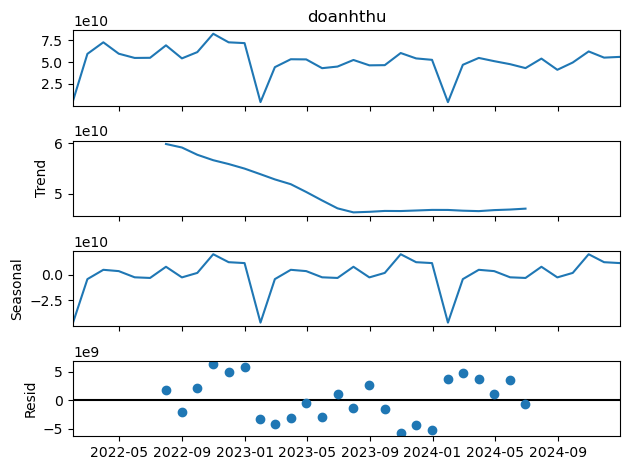

In [10]:
import statsmodels.api as sm

ts_pm = df_pm_monthly.set_index('matg')['doanhthu']

# Phân tích mùa vụ theo năm
res_add = sm.tsa.seasonal_decompose(ts_pm, model='additive', period=12)
res_add.plot()
plt.show()


In [11]:

# Đổi tên các cột để phù hợp với yêu cầu của Prophet:
# 'Order_Date' đổi thành 'ds' và 'Sales' đổi thành 'y' (giá trị cần dự báo)
monthly_data_pm = df_pm_monthly.rename(columns={'matg': 'ds', 'doanhthu': 'y'})

# Hiển thị 5 dòng đầu của dữ liệu đã xử lý
monthly_data_pm.head(5)


,ds,y
0,2022-01-31,5.739045e+09
1,2022-02-28,5.944197e+10
2,2022-03-31,7.266910e+10
3,2022-04-30,5.963547e+10
4,2022-05-31,5.478872e+10


***Huấn luyện mô hình***

In [12]:
from prophet import Prophet


# Tạo DataFrame chứa ngày lễ và ảnh hưởng chiến dịch
holidays = pd.DataFrame({
  'holiday': ['Tet2022', 'ChuyenDoiSo2022', 'Tet2023', 'ChuyenDoiSo2023', 'Tet2024', 'ChuyenDoiSo2024'],
  'ds': pd.to_datetime(['2022-02-01', '2022-10-10',  # Ngày bắt đầu ảnh hưởng Tết và ngày Chuyển đổi số
                         '2023-01-22', '2023-10-10',  # Tết và ngày Chuyển đổi số
                         '2024-02-10', '2024-10-10']),  # Tết và ngày Chuyển đổi số năm 2024
  'lower_window': [-7, -7, -7, -7, -7, -7],  # Ảnh hưởng trước ngày lễ (7 ngày trước Tết và ngày 10-10)
  'upper_window': [7, 1, 7, 1, 7, 1],        # Ảnh hưởng sau ngày lễ (7 ngày sau Tết, 1 ngày sau ngày 10-10)
})

holidays['ds'] = pd.to_datetime(holidays['ds'])  # Chuyển đổi thành datetime

# Khởi tạo mô hình Prophet
model = Prophet(holidays=holidays, 
                yearly_seasonality=True,   # Nếu có tính mùa vụ theo năm
)  # Nếu không có mùa vụ theo tuần


# Huấn luyện mô hình Prophet với dữ liệu lịch sử
# Prophet sẽ học các đặc điểm trong dữ liệu như xu hướng (trend),
# mùa vụ (seasonality), và yếu tố bất thường (holidays/events).
model.fit(monthly_data_pm)

# Tạo một DataFrame mới chứa các mốc thời gian lịch sử và tương lai (12 tháng tiếp theo).
future = model.make_future_dataframe(periods=12, freq='M')

# Dự báo giá trị tương lai dựa trên mô hình Prophet đã huấn luyện
forecast = model.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 1000000000))
# Lấy doanh thu thực tế trong dữ liệu lịch sử
actual_data_pm = monthly_data_pm['y']

# Lấy giá trị dự báo mà Prophet đã khớp trên dữ liệu lịch sử (fitted values)
fitted_data_pm = forecast['yhat'][:len(monthly_data_pm)]

# Lấy giá trị dự báo cho 12 tháng tiếp theo (giá trị tương lai)
forecast_data_pm = forecast['yhat'][len(monthly_data_pm):]


09:48:56 - cmdstanpy - INFO - Chain [1] start processing
09:48:56 - cmdstanpy - INFO - Chain [1] done processing


***Trực quan hóa kết quả dự báo***

In [26]:
import plotly.graph_objects as go

# Tạo một figure
fig = go.Figure()

# Thêm dữ liệu thực tế (Doanh thu thực tế)
fig.add_trace(go.Scatter(
    x=monthly_data_pm['ds'],
    y=actual_data_pm,
    mode='lines',
    name='Doanh thu thực tế',
    line=dict(color='green'),
    hoverinfo='x+y+name',  # Hiển thị x và y khi hover
))

# Thêm dữ liệu dự đoán (Doanh thu dự đoán)
fig.add_trace(go.Scatter(
    x=monthly_data_pm['ds'],
    y=fitted_data_pm,
    mode='lines',
    name='Doanh thu dự đoán',
    line=dict(color='blue'),
    hoverinfo='x+y+name',
))

# Thêm dữ liệu dự báo (Doanh thu dự báo tương lai)
fig.add_trace(go.Scatter(
    x=forecast['ds'][len(monthly_data_pm):],
    y=forecast_data_pm,
    mode='lines',
    name='Doanh thu dự báo 12 tháng tiếp theo',
    line=dict(color='red'),
    hoverinfo='x+y+name',
))

# Cập nhật layout
fig.update_layout(
    title="Mô hình dự đoán Prophet",
    xaxis_title="Thời gian",
    yaxis_title="Doanh thu",
    legend_title="Dữ liệu",
    template="plotly_white"  # Bạn có thể thay đổi giao diện tại đây
)

# Hiển thị biểu đồ
fig.update_layout(
    title="Dự đoán doanh thu cho nhóm sản phẩm phần mềm",
    xaxis_title="Thời gian",
    yaxis_title="Doanh thu",
    legend_title="Dữ liệu",
    template="plotly_white",
    width=1000,   # Chiều rộng biểu đồ (px)
    height=400   # Chiều cao biểu đồ (px)
)


In [14]:
# Tính chỉ số R-squared để đánh giá mức độ khớp (fitted) của mô hình trên dữ liệu lịch sử
r2_fitted_pm = 1 - np.sum((actual_data_pm - fitted_data_pm) ** 2) / np.sum((actual_data_pm - actual_data_pm.mean()) ** 2)

# Hiển thị giá trị R-squared đã tính toán
print(f"R-squared score for fitted data: {r2_fitted_pm:.2f}")


R-squared score for fitted data: 0.97


### Dự đoán doanh thu cho nhóm sản phẩm phụ kiện

***Phân rã chuỗi thời gian***

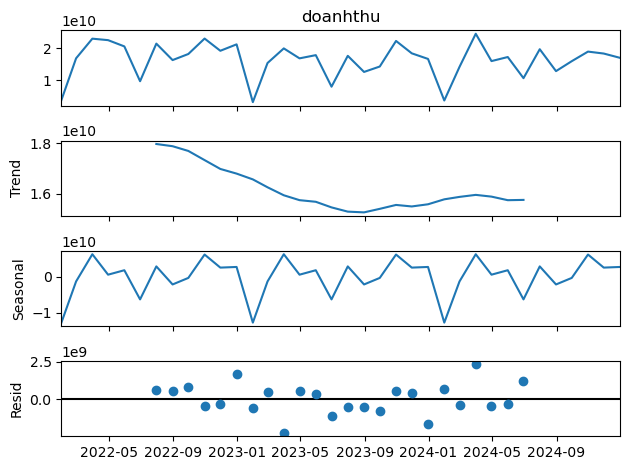

In [ ]:
import statsmodels.api as sm

ts_pk = df_pk_monthly.set_index('matg')['doanhthu']
res_add = sm.tsa.seasonal_decompose(ts_pk, model='additive', period=12)
res_add.plot()
plt.show()


***Chuẩn bị dữ liệu cho huấn luyện mô hình***

In [ ]:

# Đổi tên các cột để phù hợp với yêu cầu của Prophet:
# 'Order_Date' đổi thành 'ds' và 'Sales' đổi thành 'y' (giá trị cần dự báo)
monthly_data_pk = df_pk_monthly.rename(columns={'matg': 'ds', 'doanhthu': 'y'})

# Hiển thị 5 dòng đầu của dữ liệu đã xử lý
monthly_data_pk.head(5)

,ds,y
0,2022-01-31,3.875355e+09
1,2022-02-28,1.687497e+10
2,2022-03-31,2.299172e+10
3,2022-04-30,2.252974e+10
4,2022-05-31,2.058302e+10


***Huấn luyện mô hình***

In [ ]:
from prophet import Prophet

# Tạo DataFrame chứa ngày lễ và ảnh hưởng chiến dịch
holidays = pd.DataFrame({
  'holiday': ['Tet2022', 'ChuyenDoiSo2022', 'Tet2023', 'ChuyenDoiSo2023', 'Tet2024', 'ChuyenDoiSo2024'],
  'ds': pd.to_datetime(['2022-02-01', '2022-10-10'
                         '2023-01-22', '2023-10-10', 
                         '2024-02-10', '2024-10-10']), 
  'lower_window': [-7, -7, -7, -7, -7, -7],  # Ảnh hưởng trước ngày lễ (7 ngày trước Tết và ngày 10-10)
  'upper_window': [7, 1, 7, 1, 7, 1],        # Ảnh hưởng sau ngày lễ (7 ngày sau Tết, 1 ngày sau ngày 10-10)
})

holidays['ds'] = pd.to_datetime(holidays['ds'])  # Chuyển đổi thuộc tính thời gian của ngày lễ thành datetime

# Huấn luyện mô hình Prophet
model = Prophet(holidays=holidays, yearly_seasonality=True) 
model.fit(monthly_data_pk)

# Tạo một DataFrame mới chứa các mốc thời gian lịch sử và tương lai (12 tháng tiếp theo).
future = model.make_future_dataframe(periods=12, freq='M')

# Dự báo giá trị tương lai dựa trên mô hình Prophet đã huấn luyện
forecast = model.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 1000000000))
# Lấy doanh thu thực tế trong dữ liệu lịch sử
actual_data_pk = monthly_data_pk['y']

# Lấy giá trị dự báo mà Prophet đã khớp trên dữ liệu lịch sử (fitted values)
fitted_data_pk = forecast['yhat'][:len(monthly_data_pk)]

# Lấy giá trị dự báo cho 12 tháng tiếp theo (giá trị tương lai)
forecast_data_pk = forecast['yhat'][len(monthly_data_pk):]


09:48:58 - cmdstanpy - INFO - Chain [1] start processing
09:48:58 - cmdstanpy - INFO - Chain [1] done processing


***Trực quan hóa kết quả dự báo***

In [28]:
import plotly.graph_objects as go

# Tạo một figure
fig = go.Figure()

# Thêm dữ liệu thực tế (Doanh thu thực tế)
fig.add_trace(go.Scatter(
    x=monthly_data_pk['ds'],
    y=actual_data_pk,
    mode='lines',
    name='Doanh thu thực tế',
    line=dict(color='green'),
    hoverinfo='x+y+name',  # Hiển thị x và y khi hover
))

# Thêm dữ liệu dự đoán (Doanh thu dự đoán)
fig.add_trace(go.Scatter(
    x=monthly_data_pk['ds'],
    y=fitted_data_pk,
    mode='lines',
    name='Doanh thu dự đoán',
    line=dict(color='blue'),
    hoverinfo='x+y+name',
))

# Thêm dữ liệu dự báo (Doanh thu dự báo tương lai)
fig.add_trace(go.Scatter(
    x=forecast['ds'][len(monthly_data_pk):],
    y=forecast_data_pk,
    mode='lines',
    name='Doanh thu dự báo 12 tháng tiếp theo',
    line=dict(color='red'),
    hoverinfo='x+y+name',
))

# Hiển thị biểu đồ
fig.update_layout(
    title="Dự đoán doanh thu cho nhóm sản phẩm phụ kiện",
    xaxis_title="Thời gian",
    yaxis_title="Doanh thu",
    legend_title="Dữ liệu",
    template="plotly_white",
    width=1000,   # Chiều rộng biểu đồ (px)
    height=400   # Chiều cao biểu đồ (px)
)


# Hiển thị biểu đồ
fig.show()


### Đánh giá mô hình dự báo

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# So sánh giữa dữ liệu thực tế và dữ liệu mô hình đã khớp (fitted)
y_true = actual_data_pk.values
y_pred = fitted_data_pk.values

# Tính R², MAE, RMSE
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# In kết quả đánh giá
print(f"R² score phụ kiện: {r2:.4f}")
print(f"MAE phụ kiện: {mae:,.0f}")

R² score phụ kiện: 0.9704
MAE phụ kiện: 704,873,565


In [32]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# So sánh giữa dữ liệu thực tế và dữ liệu mô hình đã khớp (fitted)
y_true = actual_data_pm.values
y_pred = fitted_data_pm.values

# Tính R², MAE, RMSE
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# In kết quả đánh giá
print(f"R² score phần mềm: {r2:.4f}")
print(f"MAE phần mềm: {mae:,.0f}")

R² score phần mềm: 0.9662
MAE phần mềm: 2,563,937,444


In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# So sánh giữa dữ liệu thực tế và dữ liệu mô hình đã khớp (fitted)
y_true = actual_data_mt.values
y_pred = fitted_data_mt.values

# Tính R², MAE, RMSE
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# In kết quả đánh giá
print(f"R² score máy tính: {r2:.4f}")
print(f"MAE máy tính: {mae:,.0f}")

R² score máy tính: 0.9457
MAE máy tính: 816,323,352
